# Enhanced House Price Predictions
### Release 1.0 - April, 2020
### Paulo Breviglieri

 <img src="https://i.imgur.com/iJHPHWh.png" width="1024" height="203">
 <p style="text-align: left"><i>Ames, Iowa<i></p>

## Foreword

<p style="text-align: justify">This notebook is intended to be educational above all, and aims primarily at providing fellow coders, data science beginners in particular, with a detailed description of all tasks related to a typical machine learning regression exercise. As such, the code and the comments included herein are designed to be as much informational as possible. Code optimization was in turn granted some lower priority for the benefit of logic clarity and understanding.</p>

<p style="text-align: justify">Code was originally developed in response to Kaggle's "Housing Prices Competition for Kaggle Learn Users" and "House Prices: Advanced Regression Techniques" competitions. Although scoring was never a concern or a final goal, honorable positions in the competition rankings were achieved with only three predictions submitted on April 24, 2020.</p>

## 1. Introduction

<p style="text-align: justify">This machine learning regression exercise was inspired by Kaggle's "Housing Prices Competition for Kaggle Learn Users". Based on the <a href="http://jse.amstat.org/v19n3/decock.pdf">Ames Housing dataset</a>, compiled by Dean De Cock (Truman State University) in 2011 for use in general data science education, the competition requests predictions of sale prices for a set of residential properties in Ames, Iowa.</p>
<p style="text-align: justify">The original dataset comprises 2930 observations, for which 79 explanatory variables (the independent variables) and sale prices (the dependent variable) are known and supplied. In the competition, Kaggle furnished optimized train and test subsets of the original Ames Housing dataset with 1460 and 1459 observations, respectively. Sale prices are disclosed for the training set and must be predicted for the test set. Submissions are ranked based on the Mean Absolute Error (MAE) derived from predicted and actual sale prices for the 1459 observations in the test set.</p>
<p style="text-align: justify">This notebook covers all steps of a typical regression program, including an initial setup, data preprocessing, machine learning (advanced regression) and result analysis. Code is supplied also for the submission of predictions to Kaggle's competition.</p>
<p style="text-align: justify">Logic enhancement and code forking are welcome and encouraged provided that proper referencing to this work is made. Thank you.</p>

## 2. Initial setup

### 2.1. Importing required libraries

<p style="text-align: justify">Along with traditional libraries imported for tensor manipulation, mathematical operations and graphics development, specific machine learning modules are used in this exercise: regressors (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html">ElasticNet</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html">LassoCV</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html">RidgeCV</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html">SVR</a>, <a href="https://xgboost.readthedocs.io/en/latest/#">XGBoost</a>, <a href="http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/">StackingCVRegressor</a>), cross validation engines, a scaler and metrics methods. Comments on the choice of regressors are provided in Section 4.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

import warnings

### 2.2. Customized functions

<p style="text-align: justify">Functions were developed to assist with graphical analysis of specific dataset elements (features or observations) and with cross-validation scoring of regression strategies. Please refer to the respective docstrings below for details. Note that all function variable names, by coding principle, start with the "f_" string, allowing for containerized processing within the function execution environment, not affecting global variables.</p>

In [2]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='r')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()


def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12, 10))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()
    
    
def xval_rmse_scoring(f_model, f_X, f_y, f_cv):
    """
    Returns a machine learning model cross-validated score based on the Root Mean Squared Error (RMSE) metric.
    
    Keyword arguments:
    
    f_model     Machine learning model.
                Object instance
    f_X_        Tensor containing features for modeling.
                Pandas dataframe
    f_y         Tensor containing targets for modeling.
                Pandas series
    f_cv        Cross-validation splitting strategy.
                Please refer to scikit-learn's model_selection cross_val_score for further information.
    """
    return np.sqrt(-cross_val_score(f_model, f_X, f_y,
                                    scoring='neg_mean_squared_error',
                                    cv=f_cv))


### 2.3. Importing required datasets into dataframes

<p style="text-align: justify">Variables starting with numbers are renamed properly for further calling as dataframe elements. The original 'Id' feature is dropped and incorporated as index for observations.</p>

In [3]:
warnings.filterwarnings('ignore')
sns.set()
start_time = datetime.now()

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.rename(columns={"1stFlrSF": "FstFlSF", "2ndFlrSF": "SecFlSF", "3SsnPorch": "ThreeSPorch"}, inplace=True)
test.rename(columns={"1stFlrSF": "FstFlSF", "2ndFlrSF": "SecFlSF", "3SsnPorch": "ThreeSPorch"}, inplace=True)

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

train_features = train.iloc[:, :-1]
train_targets = train.iloc[:, -1]
test_features = test

### 2.4. Redefinition of specific feature types (numerical vs categorical)

<p style="text-align: justify">Specific numerical features ('MSSubClass', 'MoSold' and 'YrSold') have a discrete nature. Transforming their numerical values into strings enables further treatment as categorical features along the code.</p>

In [4]:
train_features['MSSubClass'] = train_features['MSSubClass'].astype(str)
train_features['MoSold'] = train_features['MoSold'].astype(str)
train_features['YrSold'] = train_features['YrSold'].astype(str)
test_features['MSSubClass'] = test_features['MSSubClass'].astype(str)
test_features['MoSold'] = test_features['MoSold'].astype(str)
test_features['YrSold'] = test_features['YrSold'].astype(str)

### 2.5. Segregation of numerical and categorical features

<p style="text-align: justify">Numerical and categorical features are identified and segregated into two speficic lists. Later, the whole train and test dataframes have their features reordered (numerical followed by categorical).</p>

In [5]:
features_numerical = []
features_categorical = []
for column in train_features.columns:
    if train_features[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        features_numerical.append(column)
    elif train_features[column].dtype == object:
        features_categorical.append(column)

new_order = features_numerical + features_categorical
train_features = train_features[new_order]
test_features = test_features[new_order]

## 3. Preprocessing

<p style="text-align: justify">Often neglected, high quality data preprocessing is absolutely required to achieve consistent and reliable results in machine learning. Two major goals must be considered in this step for both numerical and categorical features: reasonable replacement of missing values and proper coding, over both train and test sets. Creation of additional features may enhance the subsequent prediction effort, as described in Sections 3.3.2. and 3.4.4.</p> 

### 3.1. Initial inspection

<p style="text-align: justify">The primary aspects of the problem at hand - the sale of a residential property - must remain in sight throughout the development of the data science exercise. In this case, we must permanently keep in mind the major attributes considered by a buyer when looking for a house: land area, built area, number of units (rooms, bathrooms, kitchen etc.), overall property quality and age.</p>
<p style="text-align: justify">The train and test dataset csv files have first been imported into Excel <a href="www.kaggle.com/dataset/19825d534f4e8f800955350006ef39154ec511ee946ae3337fb4de0f5eecb480">(here)</a> for an initial evaluation. Features of similar nature were grouped together enabling a more focused analysis of the key aspects aforementioned:</p>
<ul>
    <li style="text-align: justify">Geography: MSZoning, Neighborhood, Condition1, Condition2</li>
    <li style="text-align: justify">Land: LotFrontage, LotArea, LotShape, LotConfig, LandContour, LandSlope, Street, Alley, Fence</li>
    <li style="text-align: justify">Age: YearBuilt, YearRemodAdd</li>
    <li style="text-align: justify">Building: BldgType, MSSubClass, HouseStyle</li>
    <li style="text-align: justify">Quality: Functional, OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCOnd, PoolQC</li>
    <li style="text-align: justify">Area: BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea</li>
    <li style="text-align: justify">Structure and Masonry: Foundation, MsnVnrType, MsnVnrArea</li>
    <li style="text-align: justify">Experior: RoofStyle, RoofMatl, Exterior1st, Exterior2nd</li>
    <li style="text-align: justify">Utilities: Utilities, Heating, CentraiAir, Electrical</li>
    <li style="text-align: justify">Living Units: TotRmsAbvGrd, BedroomAbvGrd, KitchenAbvGr, Fireplaces</li>
    <li style="text-align: justify">Bathrooms: BsmtFullBath, BsmtHalfBath, FullBath, HalfBath</li>
    <li style="text-align: justify">Garage: GarageType, GarageYrBlt, GarageFinish, GarageCars, PavedDrive</li>
    <li style="text-align: justify">Miscelaneous: MiscFeature, MiscVal</li>
    <li style="text-align: justify">Sales: MoSold, YrSold, SaleType, SaleCondition</li>
</ul>


### 3.2. Concatenating train and test features

<p style="text-align: justify">As features may be transformed, deleted or created along the data preprocessing phase, stacking train and test set features on top of each other facilitates such operations. Note that the training targets have been previously segregated in the 'train_targets' series, are not included in 'train_test_features' and therefore will not be manipulated at this point.</p>

In [6]:
train_test_features = pd.concat([train_features, test_features], axis=0)

### 3.3. Numerical features

#### 3.3.1. Missing values

<p style="text-align: justify">Numerical features with missing values are identified. Their names are included in a specific list and displayed.</p>

In [7]:
missing_numerical = []
for feature in features_numerical:
    if train_test_features.count()[feature] < train_test_features.shape[0]:
        missing_numerical.append(feature)
print(f'\nNumerical features with missing values before treatment: {len(missing_numerical)}\n')
print(missing_numerical)


Numerical features with missing values before treatment: 11

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


<p style="text-align: justify">Replacement strategy:</p>
<ol>
    <li style="text-align: justify">LotFrontage - Nulls replaced with the median of lot frontage values of properties in the same neighborhood, as those may be framed by the local zoning regulation.</li>
    <li style="text-align: justify">MasVnrArea - Inspection shows that nulls occur for cases where MasVnrType is also null. Replaced with zeros.</li>
    <li style="text-align: justify">BsmtFinSF1, BsmtFinSF2, BsmtUnfSF and TotalBsmtSF - Nulls correpond to cases where the property does not have a basement. Replaced with zeros.</li>
    <li style="text-align: justify">BsmtFullBath, BsmtHalfBath - Nulls correpond to cases where the property does not have a basement (see item 3 above). Replaced with zeros.</li>
    <li style="text-align: justify">GarageYrBlt, GarageArea, GarageCars - Nulls correpond to cases where the property does not have a garage. Replaced with zeros.</li>
</ol>

In [8]:
train_test_features['LotFrontage'] = train_test_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train_test_features['MasVnrArea'] = train_test_features['MasVnrArea'].fillna(0)
train_test_features['BsmtFinSF1'] = train_test_features['BsmtFinSF1'].fillna(0)
train_test_features['BsmtFinSF2'] = train_test_features['BsmtFinSF2'].fillna(0)
train_test_features['BsmtUnfSF'] = train_test_features['BsmtUnfSF'].fillna(0)
train_test_features['TotalBsmtSF'] = train_test_features['TotalBsmtSF'].fillna(0)
train_test_features['BsmtFullBath'] = train_test_features['BsmtFullBath'].fillna(0)
train_test_features['BsmtHalfBath'] = train_test_features['BsmtHalfBath'].fillna(0)
train_test_features['GarageYrBlt'] = train_test_features['GarageYrBlt'].fillna(0)
train_test_features['GarageArea'] = train_test_features['GarageArea'].fillna(0)
train_test_features['GarageCars'] = train_test_features['GarageCars'].fillna(0)

missing_numerical.clear()
for feature in features_numerical:
    if train_test_features.count()[feature] < train_test_features.shape[0]:
        missing_numerical.append(feature)
print(f'\nNumerical features with missing values after treatment: {len(missing_numerical)}')


Numerical features with missing values after treatment: 0


#### 3.3.2. Creation of new features from numerical features

<p style="text-align: justify">Whenever possible, additional features related to key aspects of the problem under analysis may be created to reinforce the weight of such aspects in the regression. In the current case (real state pricing), features associated with land area, built area, number of rooms, overall property quality and age are of supreme relevance.</p>
<p style="text-align: justify">In this sense, the following additional features are proposed:</p>
<ul>
    <li style="text-align: justify">Time elapsed since property was originally built (measured at sales year);</li>
    <li style="text-align: justify">Time elapsed since property was last remodelled (also measured at sales year);</li>
    <li style="text-align: justify">Total walled area, total porch area and total occupied area (the sum of walled and porch areas);</li>
    <li style="text-align: justify">Other rooms, equaling the number of total rooms excluding bedroom(s) and kitchen(s);</li>
    <li style="text-align: justify">Total bathrooms, with different weights for full (1.0) and half (0.5) bathrooms;</li>
    <li style="text-align: justify">Average lot depth, derived from lot area and lot frontage (rectangular lot shape assumed).</li>
</ul>

In [9]:
train_test_features['YearsSinceBuilt'] = train_test_features['YrSold'].astype(int) - train_test_features['YearBuilt']
train_test_features['YearsSinceRemod'] = train_test_features['YrSold'].astype(int) - train_test_features['YearRemodAdd']

train_test_features['TotalWalledArea'] = train_test_features['TotalBsmtSF'] + train_test_features['GrLivArea']
train_test_features['TotalPorchArea'] = train_test_features['OpenPorchSF'] + train_test_features['ThreeSPorch'] + train_test_features['EnclosedPorch'] + train_test_features['ScreenPorch'] + train_test_features['WoodDeckSF']
train_test_features['TotalOccupiedArea'] = train_test_features['TotalWalledArea'] + train_test_features['TotalPorchArea']

train_test_features['OtherRooms'] = train_test_features['TotRmsAbvGrd'] - train_test_features['BedroomAbvGr'] - train_test_features['KitchenAbvGr']
train_test_features['TotalBathrooms'] = train_test_features['FullBath'] + (0.5 * train_test_features['HalfBath']) + train_test_features['BsmtFullBath'] + (0.5 * train_test_features['BsmtHalfBath'])

train_test_features['LotDepth'] = train_test_features['LotArea'] / train_test_features['LotFrontage']

#### 3.3.3. Feature profiling

<p style="text-align: justify">Skewness may be interpreted as the extent to which a variable distribution differs from a normal distribution. Skewed variables (features) must be identified and normalized during preprocessing. Usually a variable (feature) is considered 'skewed' when its skew factor exceeds 0.5. Identification is performed with the help of scipy's methods 'skew', 'boxcox1p' and 'boxcox_normmax'.</p>

In [10]:
skew_values = train_test_features[features_numerical].apply(lambda x: skew(x))
high_skew = skew_values[skew_values > 0.5]
skew_indices = high_skew.index

<p style="text-align: justify">Visualization of distribution and correlation with the dependent variable BEFORE normalization</p>

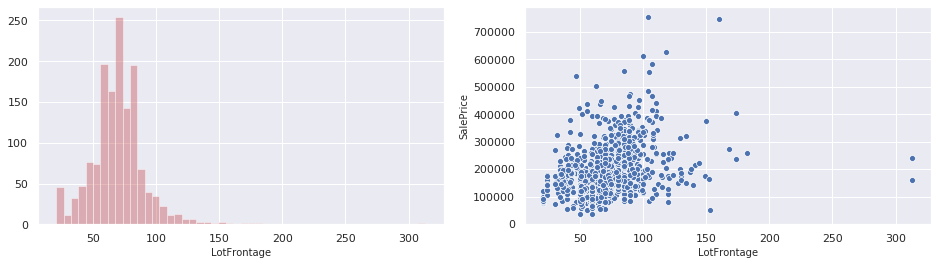

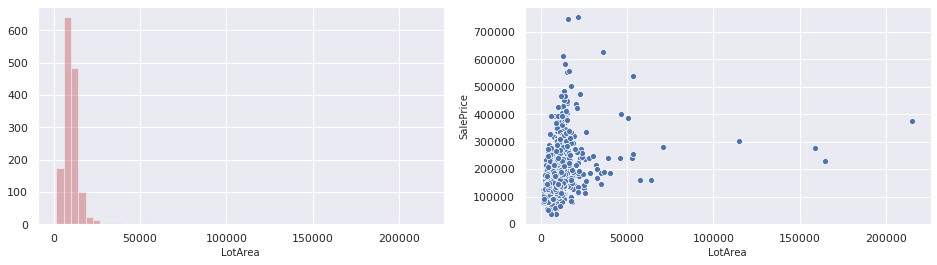

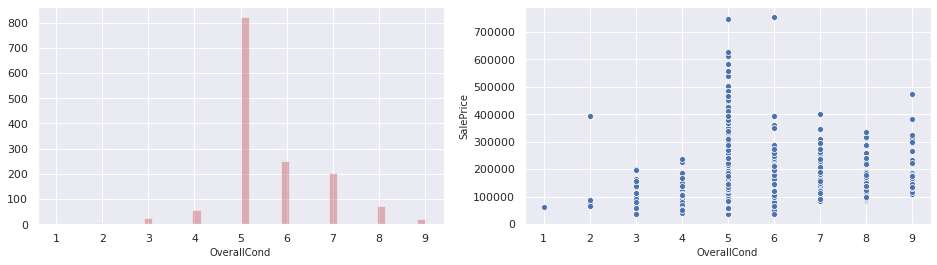

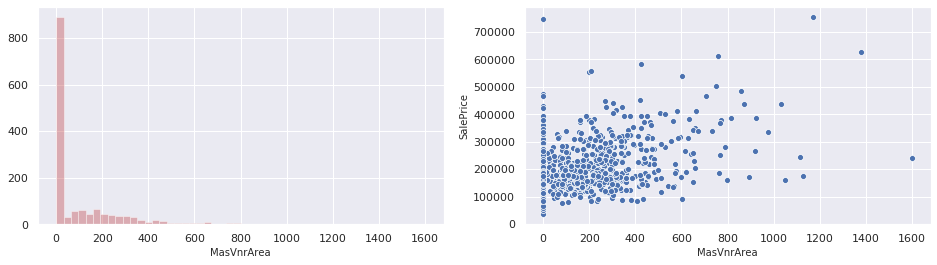

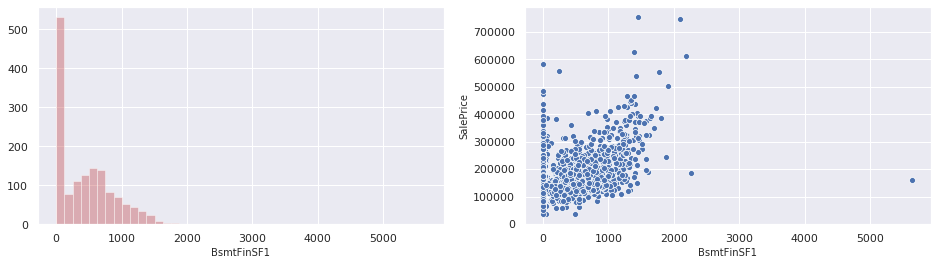

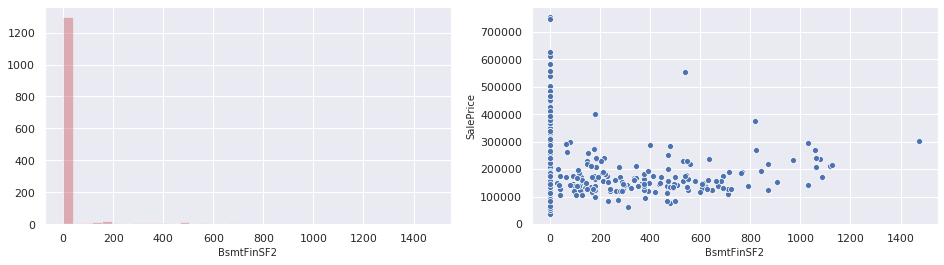

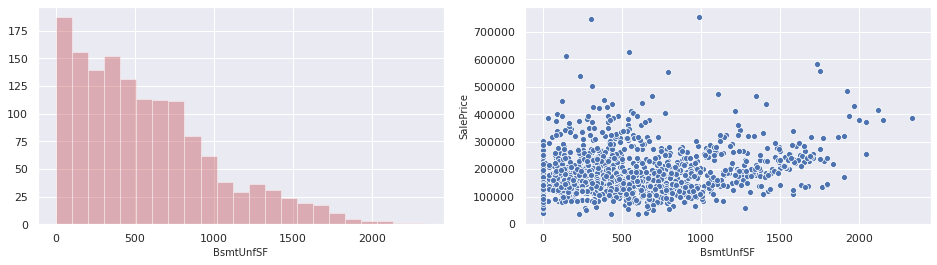

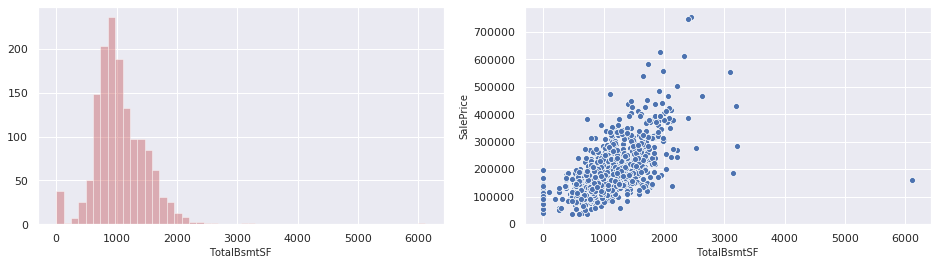

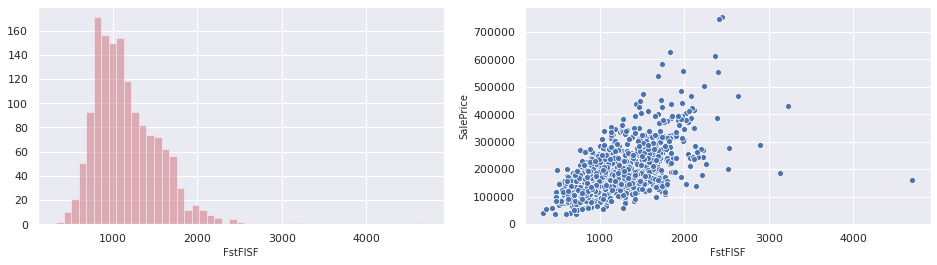

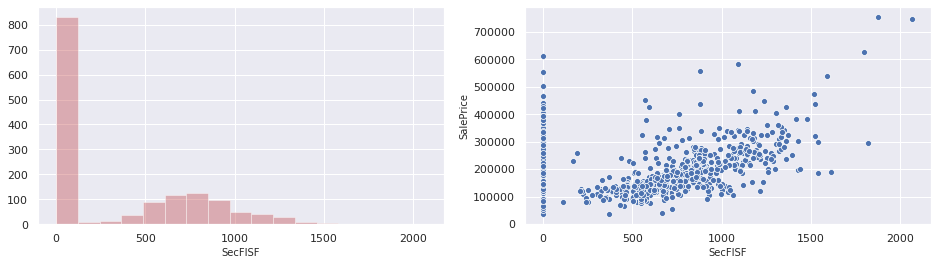

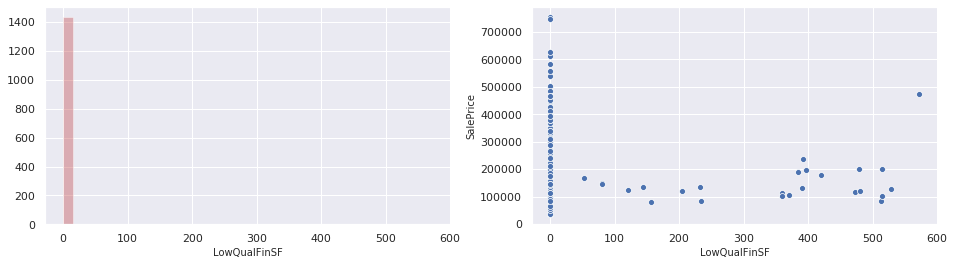

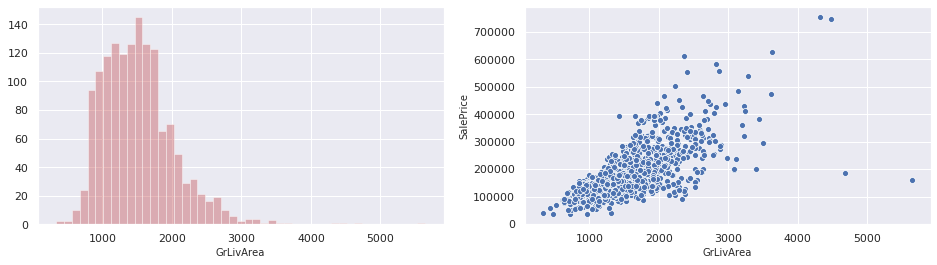

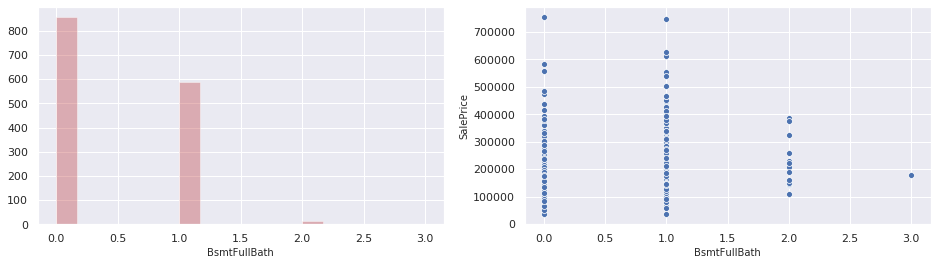

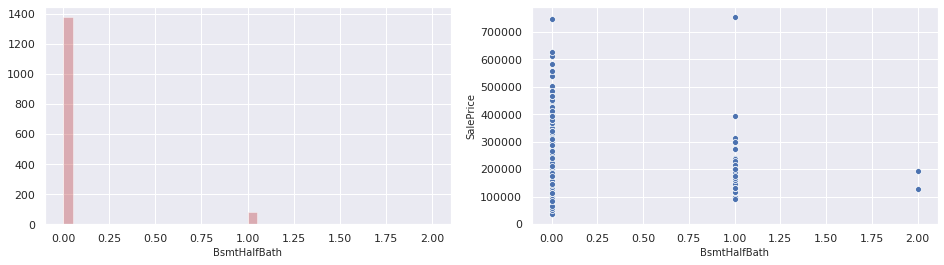

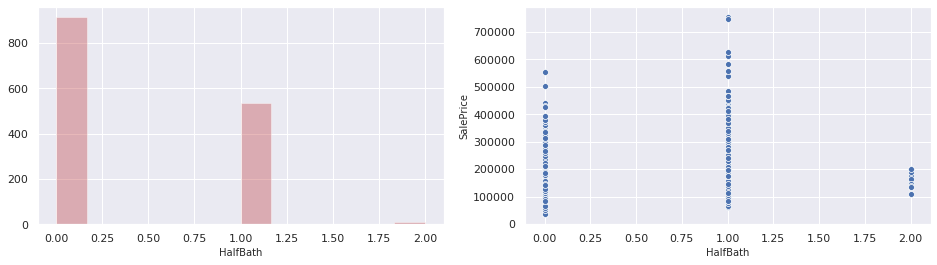

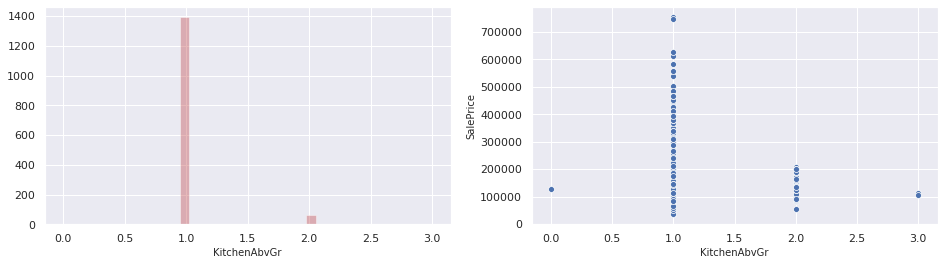

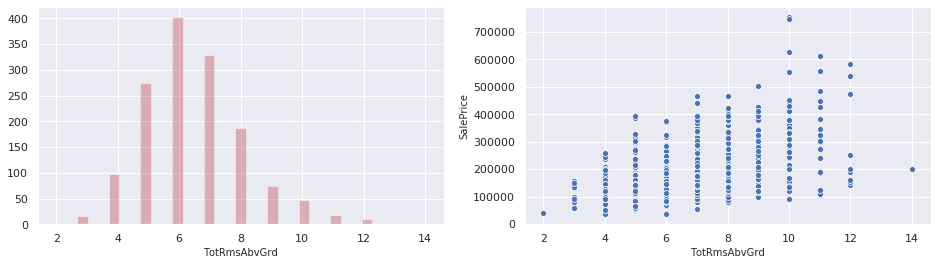

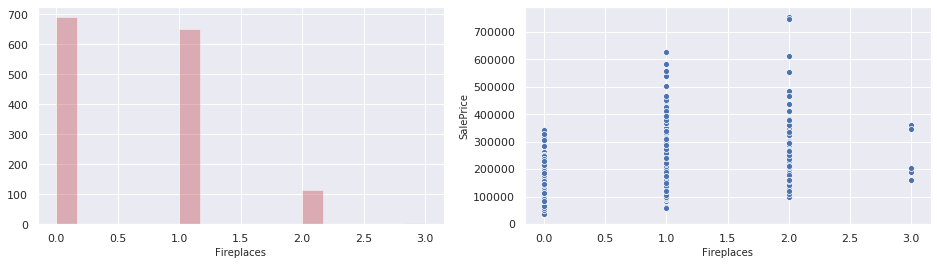

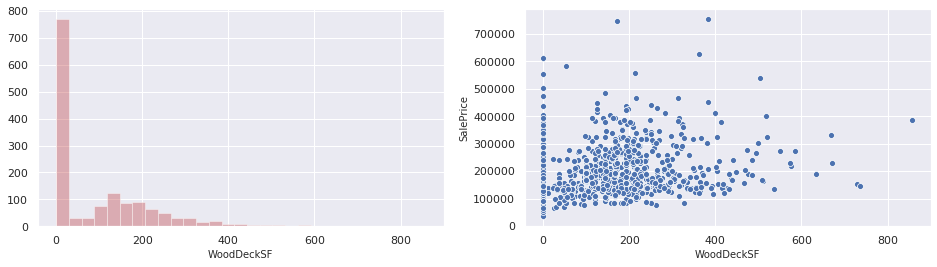

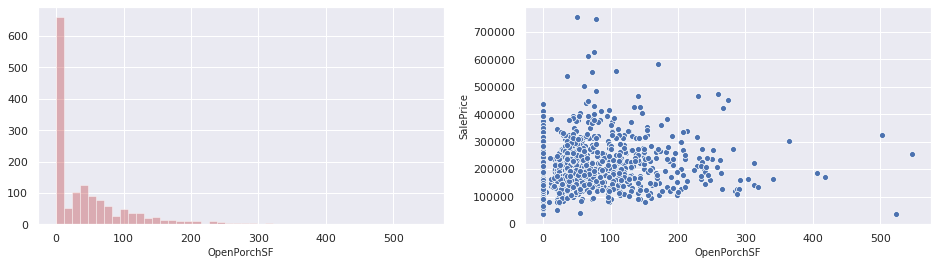

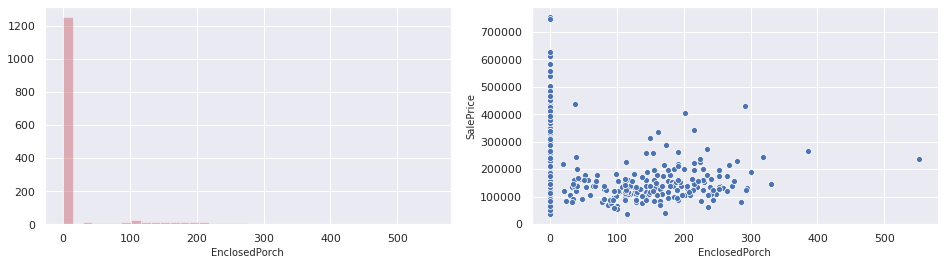

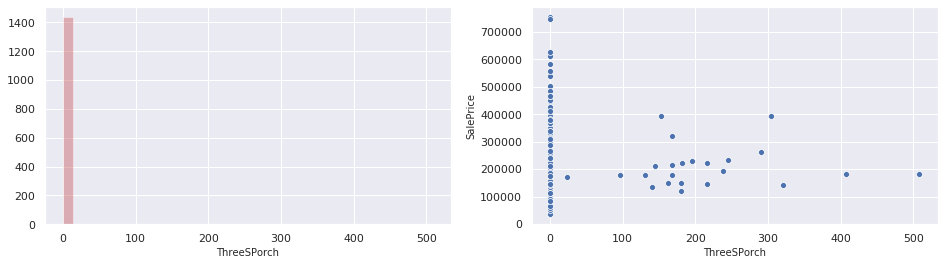

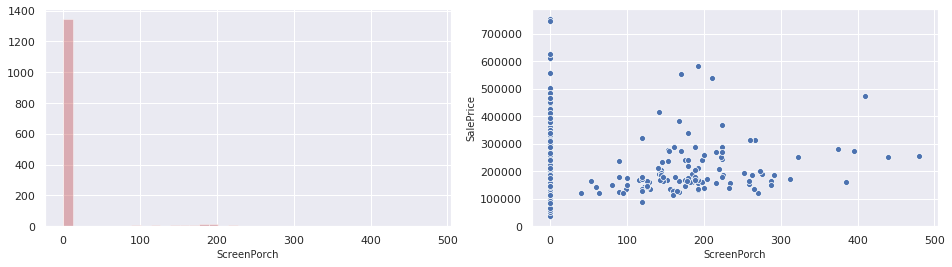

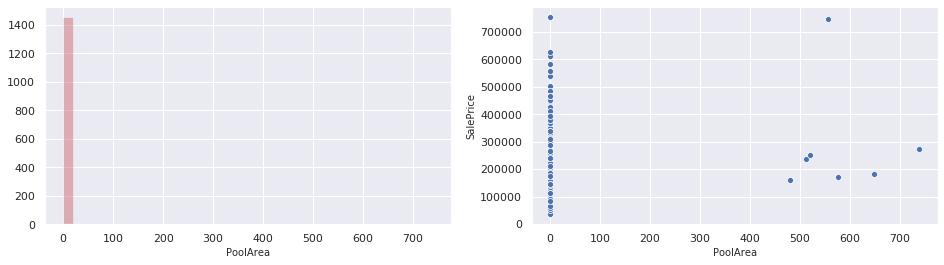

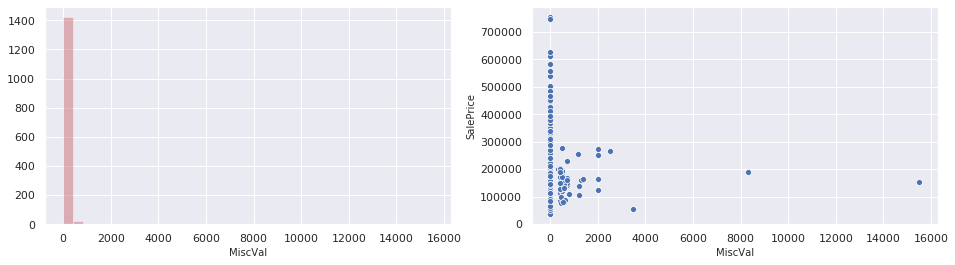

In [11]:
for index in skew_indices:
    assessment(pd.concat([train_test_features.iloc[:len(train_targets), :], train_targets], axis=1), 'SalePrice', index, -1)

In [12]:
for index in skew_indices:
    train_test_features[index] = boxcox1p(train_test_features[index], boxcox_normmax(train_test_features[index] + 1))

<p style="text-align: justify">Visualization of distribution and correlation with the dependent variable AFTER normalization</p>

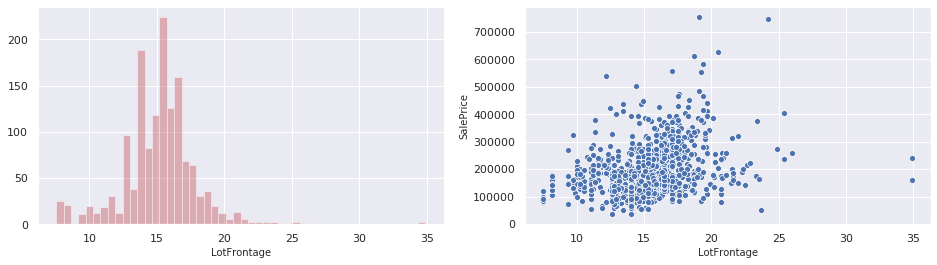

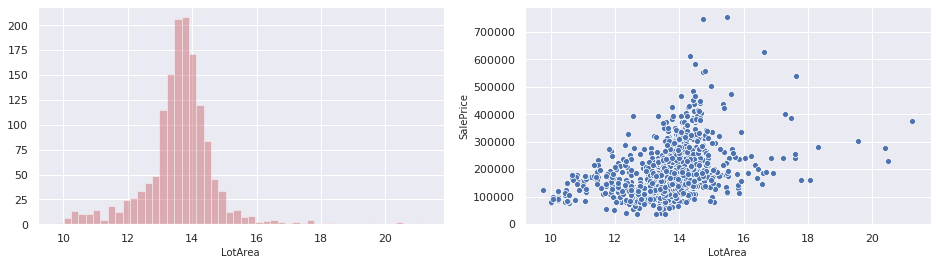

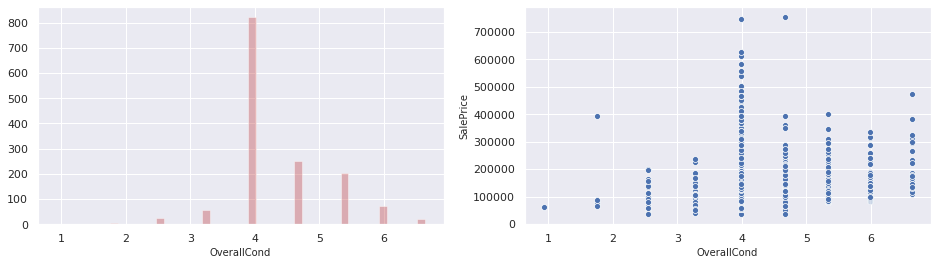

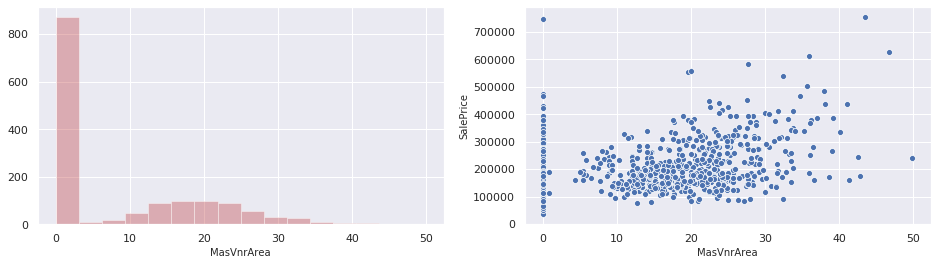

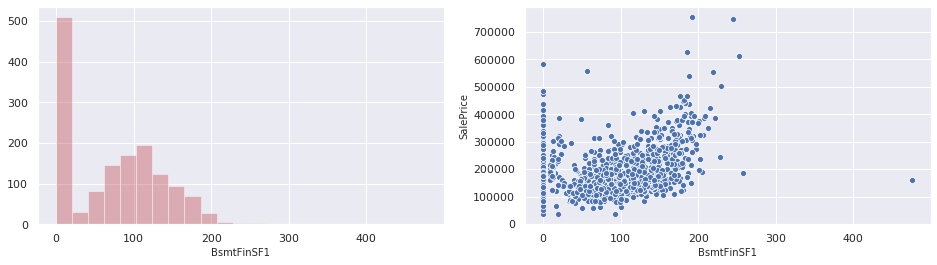

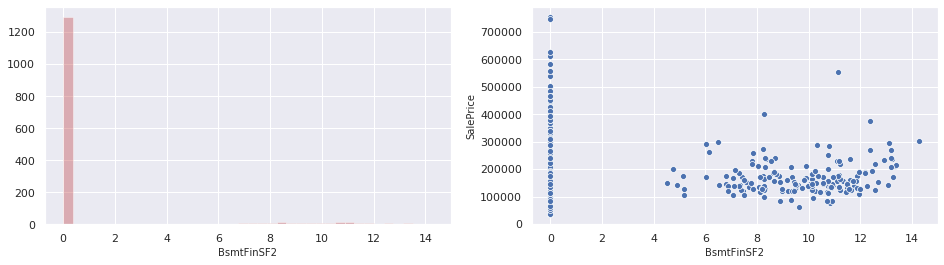

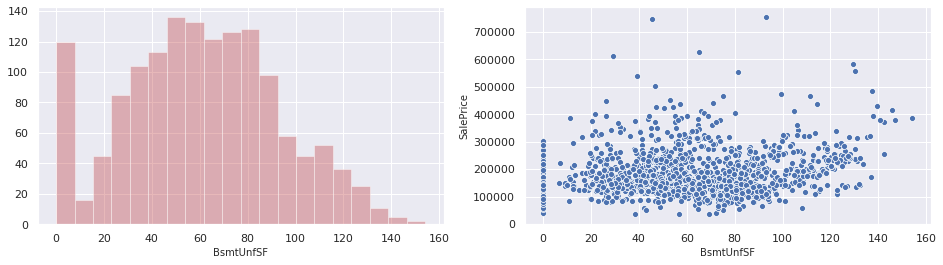

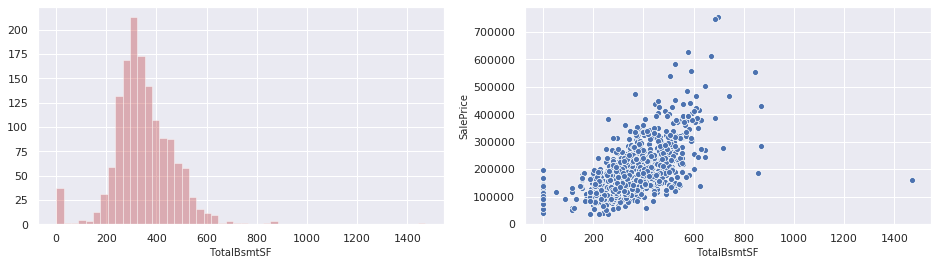

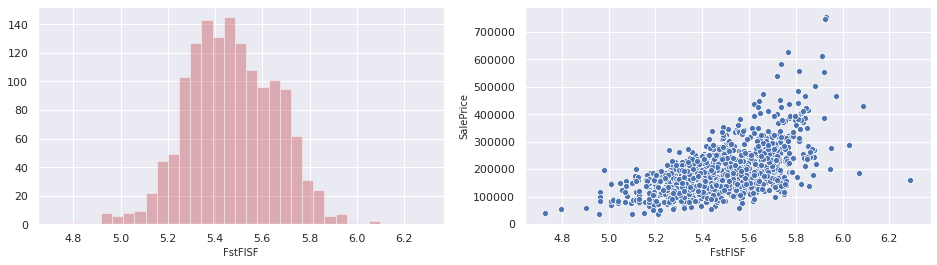

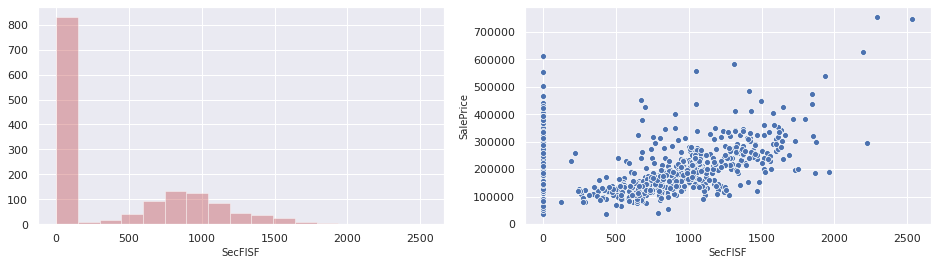

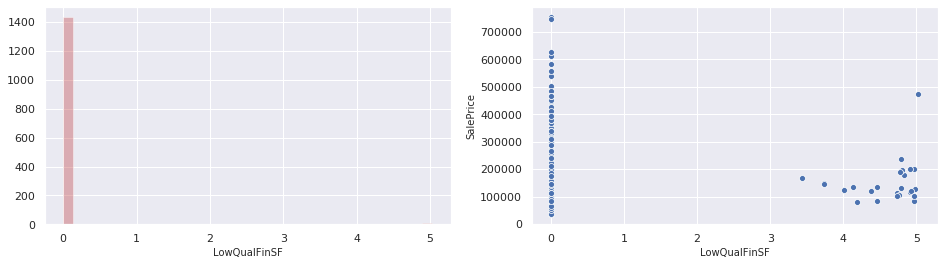

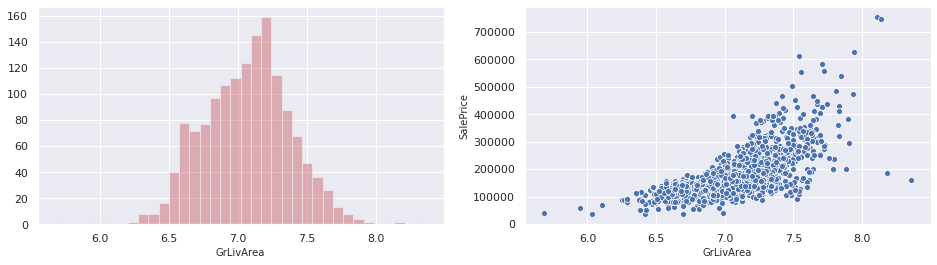

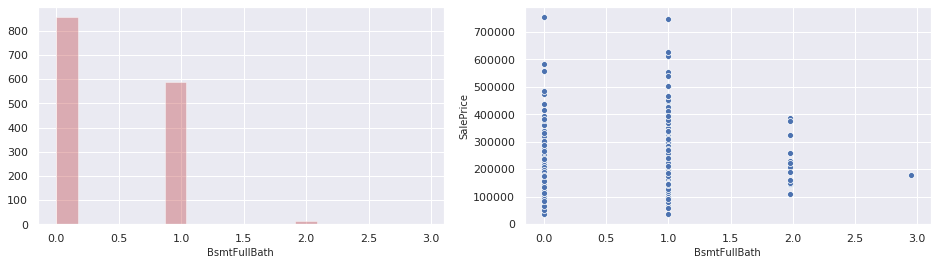

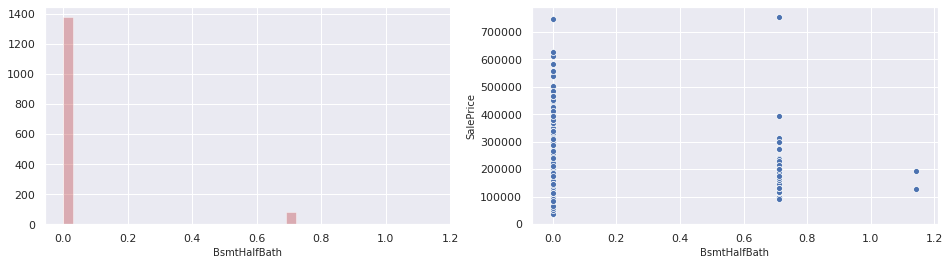

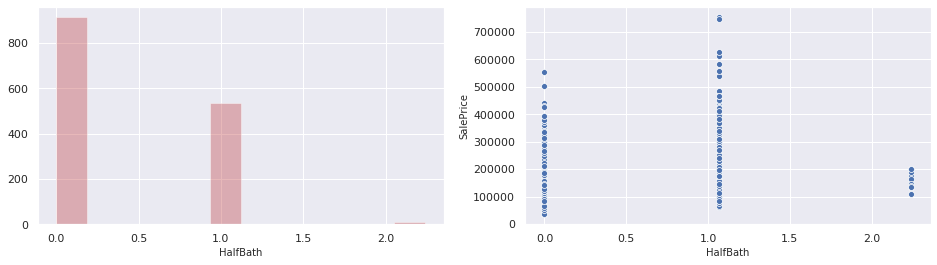

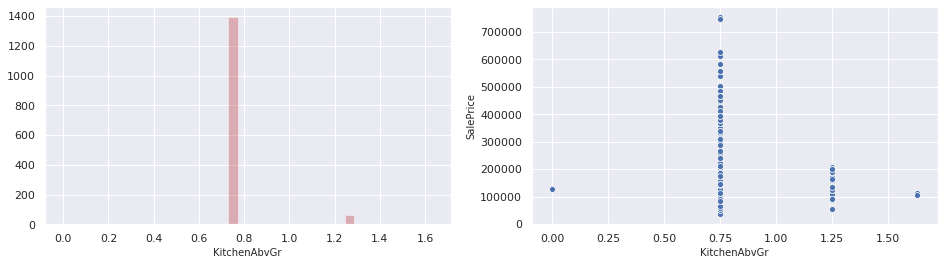

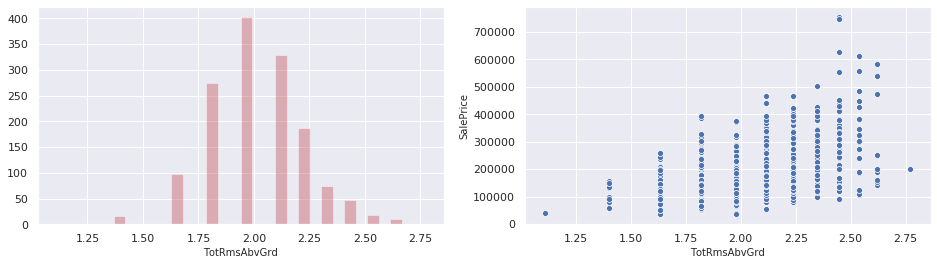

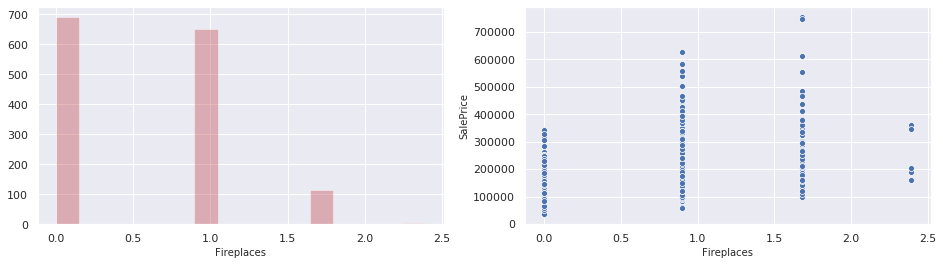

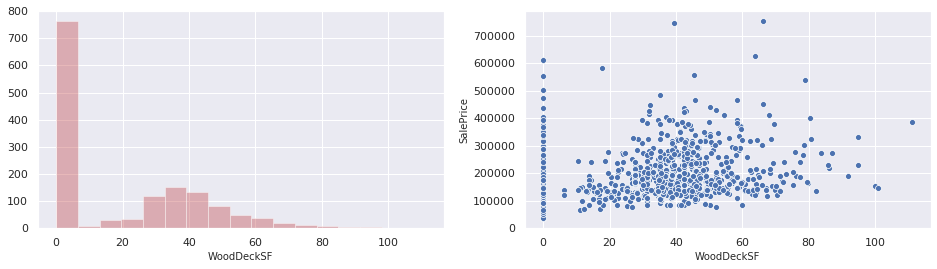

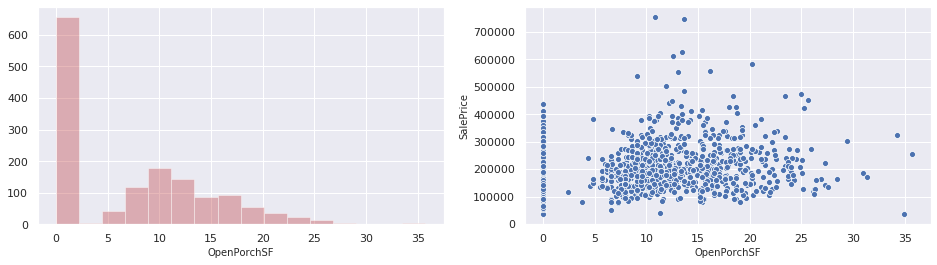

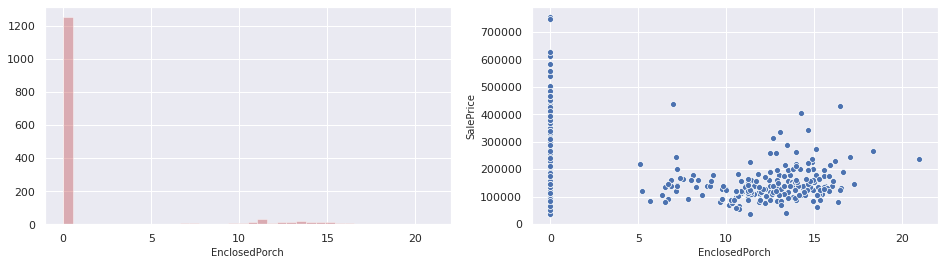

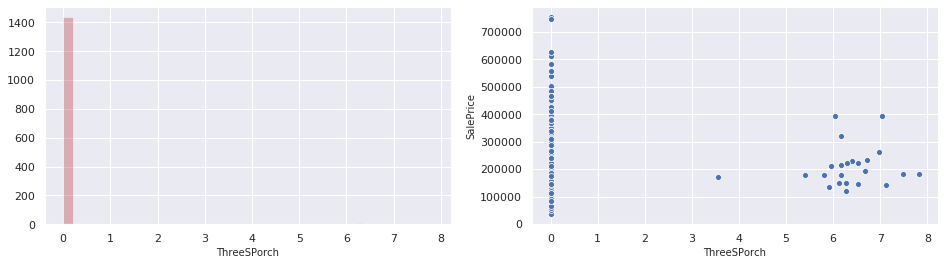

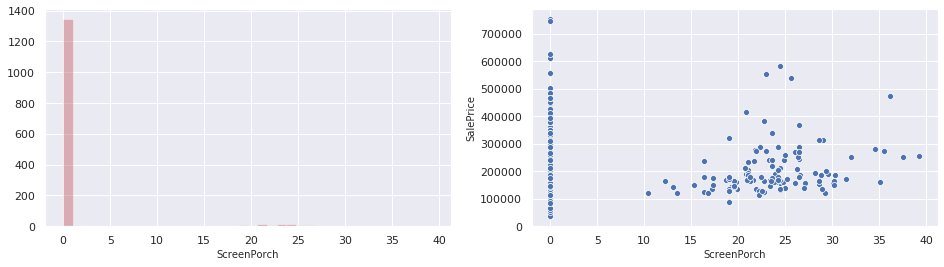

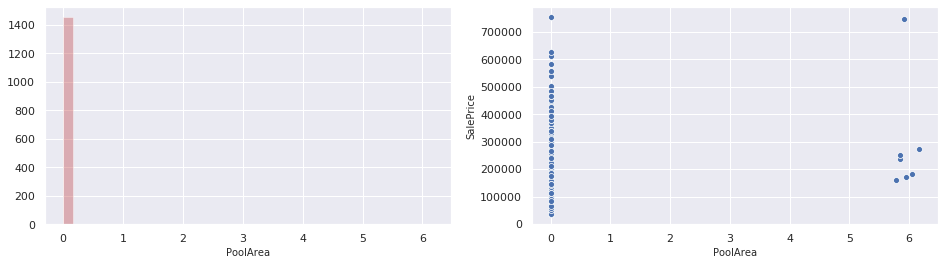

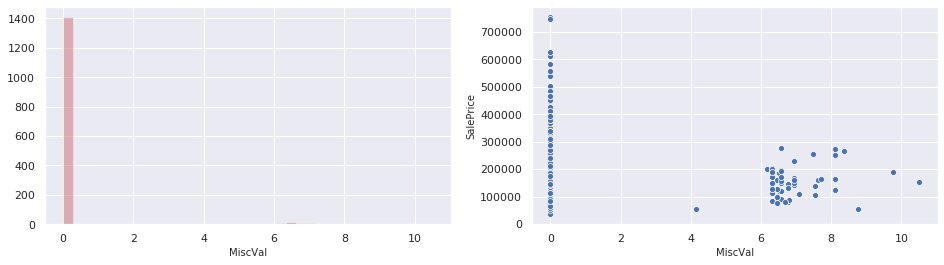

In [13]:
for index in skew_indices:
    assessment(pd.concat([train_test_features.iloc[:len(train_targets), :], train_targets], axis=1), 'SalePrice', index, -1)

<p style="text-align: justify">It is important to mention that in specific cases a skewed pattern remains even after normalization.</p>

#### 3.3.4. Identifying and dropping numerical features with predominant values

<p style="text-align: justify">Specific numerical features with one predominant value across all observations are barely correlated to the dependent value (sales prices) and therefore their prediction value is irrelevant. The accumulation of features with predominant values (zeros or ones in particular) may lead to sparse datasets and deteriorated regressions.</p>
<p style="text-align: justify">Numerical features with one predominant value present in more than 99.5% of all observations (train and test sets combined) are identified and dropped. </p>

In [14]:
numerical_features_to_be_dropped = []
for feature in features_numerical:
    predominant_value_count = train_test_features[feature].value_counts().max()
    if predominant_value_count / train_test_features.shape[0] > 0.995:
        numerical_features_to_be_dropped.append(feature)
print(f'\nNumerical features to be dropped: {numerical_features_to_be_dropped}')
train_test_features = train_test_features.drop(numerical_features_to_be_dropped, axis=1)


Numerical features to be dropped: ['PoolArea']


#### 3.3.5. Correlation

<p style="text-align: justify">Once all numerical features have been preprocessed, it is important to verify the correlation between each numerical feature and the dependent variable, as well as correlation among numerical features leading to undesired colinearity. The heatmap below provides an overview of correlation between the dependent variable ('SalePrice') and the top 15 features mostly correlated with it, as well as correlation among them.</p>

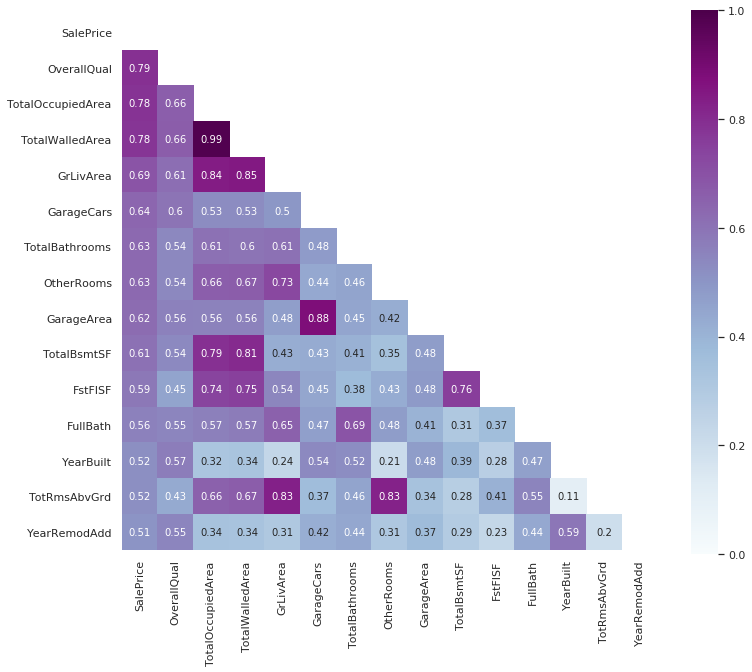

In [15]:
features_numerical = []
for column in train_features.columns:
    if train_features[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        features_numerical.append(column)

updated_train_set = pd.concat([train_test_features.iloc[:len(train_targets), :], train_targets], axis=1)

correlation_map(updated_train_set, 'SalePrice', 15)

<p style="text-align: justify">Not surprisingly, as anticipated, features related to quality, area, number of living units and age show up as the most correlated with sale prices. This reinforces the need to devote extra attention to them.</p>
<p style="text-align: justify">Additionally, the heatmap also highlights specific correlations among pairs of features. This is the case of GarageArea and GarageCars - the rationale behind them is obvious, as larger garages accommodate a higher number of vehicles. The data scientist must therefore keep an eye on them and consider dropping one of the pair elements if signs of colinearity show up.</p>

### 3.4. Categorical features

#### 3.4.1. Missing values

<p style="text-align: justify">Categorical features with missing values are identified. Their names are included in a specific list and displayed.</p>

In [16]:
missing_categorical = []
for feature in features_categorical:
    if train_test_features.count()[feature] < train_test_features.shape[0]:
        missing_categorical.append(feature)
print(f'\nCategorical features with missing values before treatment: {len(missing_categorical)}\n')
print(missing_categorical)


Categorical features with missing values before treatment: 23

['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


<p style="text-align: justify">Replacement strategy:</p>
<ol>
    <li style="text-align: justify">MSZoning - Nulls replaced with the MSZoning mode of equivalent properties of the same class (equivalent MSSubClass values).</li>
    <li style="text-align: justify">Exterior1st, Exterior2nd, Electrical, KitchenQual, Functional, SaleType - Nulls replaced with the respective modes.</li>
    <li style="text-align: justify">All other occurrences - Nulls replaced with 'None'.</li>
</ol>

In [17]:
train_test_features['MSZoning'] = train_test_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
train_test_features['Alley'] = train_test_features['Alley'].fillna('None')
train_test_features['Utilities'] = train_test_features['Utilities'].fillna('None')
train_test_features['Exterior1st'] = train_test_features['Exterior1st'].fillna(train_test_features['Exterior1st'].mode()[0])
train_test_features['Exterior2nd'] = train_test_features['Exterior2nd'].fillna(train_test_features['Exterior2nd'].mode()[0])
train_test_features['MasVnrType'] = train_test_features['MasVnrType'].fillna('None')
train_test_features['BsmtQual'] = train_test_features['BsmtQual'].fillna('None')
train_test_features['BsmtCond'] = train_test_features['BsmtCond'].fillna('None')
train_test_features['BsmtExposure'] = train_test_features['BsmtExposure'].fillna('None')
train_test_features['BsmtFinType1'] = train_test_features['BsmtFinType1'].fillna('None')
train_test_features['BsmtFinType2'] = train_test_features['BsmtFinType2'].fillna('None')
train_test_features['Electrical'] = train_test_features['Electrical'].fillna(train_test_features['Electrical'].mode()[0])
train_test_features['KitchenQual'] = train_test_features['KitchenQual'].fillna(train_test_features['KitchenQual'].mode()[0])
train_test_features['Functional'] = train_test_features['Functional'].fillna(train_test_features['Functional'].mode()[0])
train_test_features['FireplaceQu'] = train_test_features['FireplaceQu'].fillna('None')
train_test_features['GarageType'] = train_test_features['GarageType'].fillna('None')
train_test_features['GarageFinish'] = train_test_features['GarageFinish'].fillna('None')
train_test_features['GarageQual'] = train_test_features['GarageQual'].fillna('None')
train_test_features['GarageCond'] = train_test_features['GarageCond'].fillna('None')
train_test_features['PoolQC'] = train_test_features['PoolQC'].fillna('None')
train_test_features['Fence'] = train_test_features['Fence'].fillna('None')
train_test_features['MiscFeature'] = train_test_features['MiscFeature'].fillna('None')
train_test_features['SaleType'] = train_test_features['SaleType'].fillna(train_test_features['SaleType'].mode()[0])

missing_categorical.clear()
for feature in features_categorical:
    if train_test_features.count()[feature] < train_test_features.shape[0]:
        missing_categorical.append(feature)
print(f'\nCategorical features with missing values after treatment: {len(missing_categorical)}')


Categorical features with missing values after treatment: 0


#### 3.4.2. Identifying and dropping categorical features with predominant values

<p style="text-align: justify">Specific categorical features with one predominant value across all observations are barely correlated to the dependent value (sale prices) and therefore their prediction value is irrelevant. The accumulation of features with predominant values (zeros or ones in particular) may lead to sparse datasets and poorer regressions.</p>
<p style="text-align: justify">Categorical features with one predominant value present in more than 99.5% of all observations (train and test set combined) are identified and dropped. </p>

In [18]:
categorical_features_to_be_dropped = []
for feature in features_categorical:
    predominant_value_count = train_test_features[feature].value_counts().max()
    if predominant_value_count / train_test_features.shape[0] > 0.995:
        categorical_features_to_be_dropped.append(feature)
print(f'\nCategorical features to be dropped: {categorical_features_to_be_dropped}')
train_test_features = train_test_features.drop(categorical_features_to_be_dropped, axis=1)


Categorical features to be dropped: ['Street', 'Utilities', 'PoolQC']


#### 3.4.3. Feature encoding - Categorical ordinal

<p style="text-align: justify">Categorical values must be quantified into numerical equivalents to be properly processed by machine learning algorithms. Mapped encoding is applied to categorical ordinal features, where feature values have a clear ranking nature among themselves. One hot encoding is applied to categorical nominal features, where there is no such evident ranking nature.</p>

In [19]:
map1 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
set1 = ['ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'HeatingQC',
        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
for feature in set1:
    train_test_features[feature] = train_test_features[feature].replace(map1)

map2 = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
train_test_features['BsmtExposure'] = train_test_features['BsmtExposure'].replace(map2)

map3 = {'GLQ': 4,'ALQ': 3,'BLQ': 2,'Rec': 3,'LwQ': 2,'Unf': 1,'None': 0}
set3 = ['BsmtFinType1', 'BsmtFinType2']
for feature in set3:
    train_test_features[feature] = train_test_features[feature].replace(map3)

map4 = {'Y': 1, 'N': 0}
train_test_features['CentralAir'] = train_test_features['CentralAir'].replace(map4)

map5 = {'Typ': 3, 'Min1': 2.5, 'Min2': 2, 'Mod': 1.5, 'Maj1': 1, 'Maj2': 0.5, 'Sev': 0, 'Sal': 0}
train_test_features['Functional'] = train_test_features['Functional'].replace(map5)

#### 3.4.4. Creation of new features from coded categorical ordinal features

<p style="text-align: justify">Similar to what was proposed for numerical features, additional features may be derived from recently coded categorical features to emphasize key aspects of the problem under analysis. Here two new features are proposed to enhance property quality aspects:</p>
<ul>
    <li style="text-align: justify">Total garage quality, as the product of garage quality and garage conditions;</li>
    <li style="text-align: justify">Total exterior quality, as the product of exterior quality and exterior conditions.</li>
</ul>

In [20]:
train_test_features["TotalGarageQual"] = train_test_features["GarageQual"] * train_test_features["GarageCond"]
train_test_features["TotalExteriorQual"] = train_test_features["ExterQual"] * train_test_features["ExterCond"]

#### 3.4.5. Feature encoding - Categorical nominal

<p style="text-align: justify">One hot encoding is applied to categorical nominal features, where there is no evident ranking nature among categories. Please note that the Pandas 'get_dummies' method is applied to the whole 'train_test_features' dataframe. Existing numerical features will not be affected by this operation and remain as they are. Only categorical features will be coded hereby.</p>

In [21]:
train_test_features = pd.get_dummies(train_test_features).reset_index(drop=True)

### 3.5. Dependent variable (SalePrice) treatment

<p style="text-align: justify">The dependent variable is right skewed (i.e. lower value observations are predominant and higher value observations are dispersed over a longer right tail). Normalization of the dependent variable through log transformation is highly recommended and performed.</p>

In [22]:
train_targets_skew = skew(train_targets)
print(f'Dependent variable skew factor: {train_targets_skew:.2f}')

Dependent variable skew factor: 1.88


In [23]:
y_train = np.log1p(train_targets)

<p style="text-align: justify">The charts below illustrate the dependent variable distribution before and after log transformation.</p>

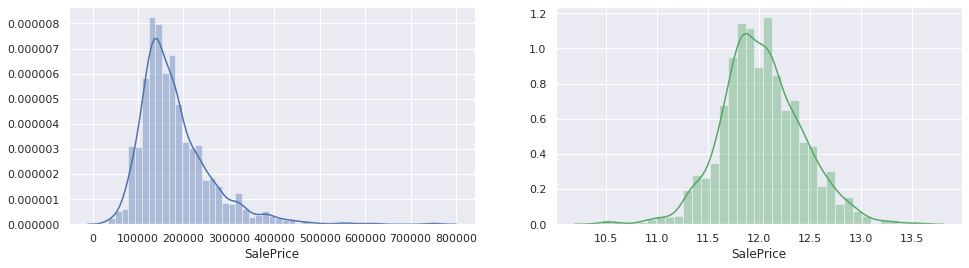

In [24]:
fig, ax =plt.subplots(1, 2, figsize=(16,4))
chart1 = sns.distplot(train_targets, ax=ax[0], color='b')
chart1.set_xlabel('SalePrice',fontsize=12)
chart2 = sns.distplot(y_train, ax=ax[1], color='g')
chart2.set_xlabel('SalePrice',fontsize=12)
fig.show()

### 3.6. Segregating train and test features

In [25]:
X_train = train_test_features.iloc[:len(train_targets), :]
X_test = train_test_features.iloc[len(train_targets):, :]
X_train_data = pd.concat([X_train, y_train], axis=1)

### 3.7. Optimizing the training set before regression

<p style="text-align: justify">In preparation for machine learning regressions, a final optimization of the training set is recommended after train and test sets have been segregated. At this point, interest resides in two very important aspects:</p>
<ul>
    <li style="text-align: justify">Features with 'zero' as the predominant value</li>
    <li style="text-align: justify">Outliers</li>
</ul>

#### 3.7.1. Features with 'zero' as the predominant value

<p style="text-align: justify">The accumulation of features with 'zero' as their predominant value (in particular those that may have been created over one hot encoding) may lead to potential overfitting. In other words, the regression models may attempt to fit (read "accommodate") to a very limited number of 'ones' present in such features and, as a consequence, their overall performance is negatively impacted. Eliminating features with a significant relative number of zeros is highly recommended. The same threshold (99.5%) adopted in Sections 3.3.4. and 3.4.2. is considered here.</p>

In [26]:
features_to_be_dropped = []
for feature in X_train.columns:
    all_value_counts = X_train[feature].value_counts()
    zero_value_counts = all_value_counts.iloc[0]
    if zero_value_counts / len(X_train) > 0.995:
        features_to_be_dropped.append(feature)
print('\nFeatures with predominant zeroes:\n')
print(features_to_be_dropped)

X_train = X_train.drop(features_to_be_dropped, axis=1).copy()
X_test = X_test.drop(features_to_be_dropped, axis=1).copy()
X_train_data = X_train_data.drop(features_to_be_dropped, axis=1).copy()


Features with predominant zeroes:

['MSSubClass_150', 'MSSubClass_40', 'LotConfig_FR3', 'Neighborhood_Blueste', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'Foundation_Stone', 'Foundation_Wood', 'Heating_Floor', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Electrical_FuseP', 'Electrical_Mix', 'GarageType_2Types', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_TenC', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleCondition_AdjLand']


#### 3.7.2. Outliers

<p style="text-align: justify">The presence of observations with one or more feature values diverging significantly from the general correlation pattern - called outliers - can also lead to overfitting. Removal of such observations is highly recommended.</p>
<p style="text-align: justify">However, when the number of observations and/or features is high, the graphical identification of outliers via chart analysis is impractical.</p>
<p style="text-align: justify">In this notebook an intelligent, automated and quantifiable approach is proposed. A particular regressor with cross-validation capabilities (LassoCV) is utilized. Regressions are iteratively executed and regression metrics (score mean and score standard deviation) are calculated. In each iteration, one specific observation is excluded from the exercise. If that observation is an outlier, regression metrics are expected to slightly improve as a result of its exclusion. After the last iteration, observations whose exclusion led to metrics improvements are identified.</p>
<p style="text-align: justify">The dropping procedure is executed for one observation at a time. At first, the most impacting observation is removed and the score is calculated. Subsequently, the second observation is also dropped, and the score is recalculated. The process is recurrently (and here manually) repeated until the regression score starts to deteriorate - at this point the n-th observation removed may carry relevant information for the overall regression and its removal negatively impacts the regression results. Time to stop.</p>
<p style="text-align: justify">Please note that this step is time/resource consuming. Accordingly, the code provided in Section 3.8.1. is commented out and must be executed only once, allowing for proper outlier mapping. Graphical inspection may be performed with the code supplied in Section 3.8.2. The outliers identified in this exercise are listed in Section 3.8.3. and dropped prior to the subsequent regression program.</p>

#### 3.7.2.1. Identifying relevant outliers with regression assistance

In [27]:
# lasso_alphas = [5e-5, 1e-4, 5e-4, 1e-3]
# lasso_outliers = make_pipeline(RobustScaler(),
#                       LassoCV(max_iter=1e7, alphas=lasso_alphas,
#                               random_state=42, cv=4))

# print(f'{"Identifying relevant outliers with LassoCV"}')
# score = xval_rmse_scoring(lasso_outliers, X_train, y_train, 4)
# print(f'{"All obs":<10}{score.mean():>14.8f}{score.std():>14.8f}')

# outlier_mean = []
# outlier_stdev = []

# for i in range(len(X_train)):
#     X_new = X_train.copy()
#     y_new = y_train.copy()
#     X_new = X_new.drop(X_new.index[i])
#     y_new = y_new.drop(y_new.index[i])
#     score = xval_rmse_scoring(lasso_outliers, X_new, y_new, 4)
#     outlier_mean.append(score.mean())
#     outlier_stdev.append(score.std())
#     print(f'{"Obs ":4}{i:<6}{score.mean():>14.8f}{score.std():>14.8f}')

# outlier_impact = pd.DataFrame(list(zip(outlier_mean, outlier_stdev)), columns =['Mean', 'St Dev'])
# outlier_lower_mean = outlier_impact.sort_values(by=['Mean'], ascending=True)
# outlier_lower_stdev = outlier_impact.sort_values(by=['St Dev'], ascending=True)
# outlier_impact.to_csv('outlier_impact.csv')

#### 3.7.2.2. Outlier inspection

<p style="text-align: justify">The example below highlights outliers identified for observations with IDs 523 and 1298. In both cases values for the feature 'GrLivArea' (red dots on the scatter charts at right) evidently diverge from the prevailing correlation pattern.</p>

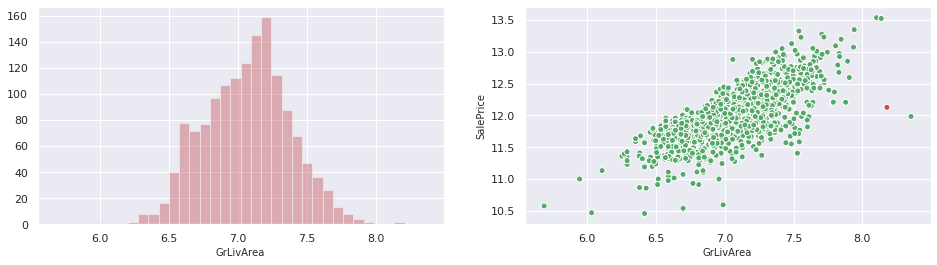

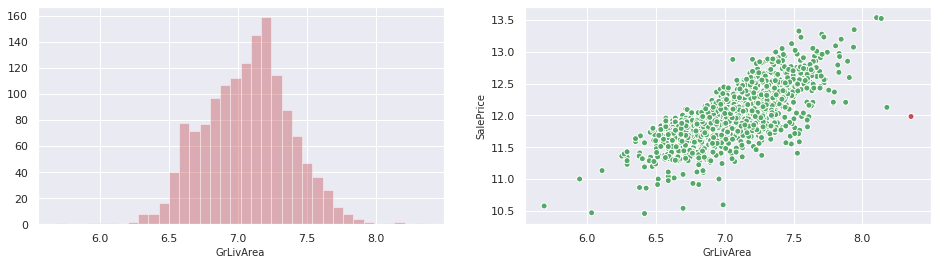

In [28]:
assessment(X_train_data, 'SalePrice', 'GrLivArea', 523)
assessment(X_train_data, 'SalePrice', 'GrLivArea', 1298)

#### 3.7.2.3. Outlier removal

In [29]:
outliers = [1298, 523, 30, 462, 588, 632, 1324]
X_train = X_train.drop(X_train.index[outliers])
y_train = y_train.drop(y_train.index[outliers])

## 4. Machine Learning - Advanced Regression

<p style="text-align: justify">An advanced, cross-validation supported regression approach is proposed herein. The strategy includes:</p>
<ol>
    <li style="text-align: justify">Generation of 'n' predictions from a set of 'n' selected regression engines (models);</li>
    <li style="text-align: justify">Generation of an additional prediction from one selected stacking model, which aggregates predictions from the 'n' regression engines utilized in (1);</li>
    <li style="text-align: justify">Generation of a final prediction through a blending mechanism combining weighed predictions from each of the 'n' predictions obtained in (1) plus the prediction of the stacking model obtained in (2).</li>
</ol>

### 4.1. Cross-validation setup

<p style="text-align: justify">KFold has been elected as the cross-validation engine of choice in this exercise. The training set is splitted in 10 folds. One fold is iteratively used at a time as a validation set.</p>

In [30]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

### 4.2. Model definition

<p style="text-align: justify">Six regression models (ElasticNetCV, LassoCV, RidgeCV, GradientBoostingRegressor, SVR and XGBoost), covering a variety of regression strategies, techniques, cross-validation capabilities and regularization features, have been elected in this exercise. Each of them has been individually tuned to minimize error metrics and best fit the training set. Referring to the each regressor documentation is highly recommended (clickable links provided in Section 2.1.). The parameters listed below are the best obtained from these individual fitting rounds.</p>
<p style="text-align: justify">Two additional regressors have also been considered:</p>
<ul>
    <li style="text-align: justify">RandomForestRegressor did not provide any substantial improvement to performance metrics and was discarded;</li>
    <li style="text-align: justify">CatBoostRegressor marginally contributed to performance metric improvements but was at last discarded due to its extremely long execution time (not even the recommendations provided <a href="https://catboost.ai/docs/concepts/speed-up-training.html">here</a> sufficed to reduce the execution time penalty).</li>
</ul>
<p style="text-align: justify">StackingCV has been chosen as the stacking regressor. In summary, StackingCV collects predictions derived from the six primary regressors and, making use of one of them, denominated 'meta regressor' (XGBoost was chosen in this exercise), produces a combined ('stacked') prediction.</p>

In [31]:
elasticnet_alphas = [5e-5, 1e-4, 5e-4, 1e-3]
elasticnet_l1ratios = [0.8, 0.85, 0.9, 0.95, 1]
elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=elasticnet_alphas,
                                        cv=kfolds, l1_ratio=elasticnet_l1ratios))

lasso_alphas = [5e-5, 1e-4, 5e-4, 1e-3]
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=lasso_alphas,
                              random_state=42, cv=kfolds))

ridge_alphas = [13.5, 14, 14.5, 15, 15.5]
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=ridge_alphas, cv=kfolds))

gradb = GradientBoostingRegressor(n_estimators=6000, learning_rate=0.01,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10,
                                  loss='huber', random_state=42)

svr = make_pipeline(RobustScaler(),
                    SVR(C=20, epsilon=0.008, gamma=0.0003))

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=6000,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006, random_state=42)

stackcv = StackingCVRegressor(regressors=(elasticnet, gradb, lasso, 
                                          ridge, svr, xgboost),
                              meta_regressor=xgboost,
                              use_features_in_secondary=True)

### 4.3. Individual model performance on cross-validation

<p style="text-align: justify">Each of the six elected regression models is hereby submitted to scoring based on the Root Mean Squared Error (RMSE) metric (mean and standard deviation provided through cross-validation). This step offers a first glance at individual model performance and is intended to support and frame subsequent stacking and blending phases.</p>

In [32]:
print('Individual model scoring on cross-validation\n')
print(f'{"Model":<20}{"RMSE mean":>12}{"RMSE stdev":>12}\n')

score = xval_rmse_scoring(elasticnet, X_train, y_train, kfolds)
print(f'{"1. ElasticNetCV":<20}{score.mean():>12.4f}{score.std():>12.4f}')

score = xval_rmse_scoring(lasso, X_train, y_train, kfolds)
print(f'{"2. LassoCV":<20}{score.mean():>12.4f}{score.std():>12.4f}')

score = xval_rmse_scoring(ridge, X_train, y_train, kfolds)
print(f'{"3. RidgeCV":<20}{score.mean():>12.4f}{score.std():>12.4f}')

score = xval_rmse_scoring(gradb, X_train, y_train, kfolds)
print(f'{"4. GradientBoosting":<20}{score.mean():>12.4f}{score.std():>12.4f}')

score = xval_rmse_scoring(svr, X_train, y_train, kfolds)
print(f'{"5. SVR":<20}{score.mean():>12.4f}{score.std():>12.4f}')

score = xval_rmse_scoring(xgboost, X_train, y_train, kfolds)
print(f'{"6. XGBoost":<20}{score.mean():>12.4f}{score.std():>12.4f}')

Individual model scoring on cross-validation

Model                  RMSE mean  RMSE stdev

1. ElasticNetCV           0.1002      0.0157
2. LassoCV                0.1002      0.0158
3. RidgeCV                0.1012      0.0159
4. GradientBoosting       0.1043      0.0191
5. SVR                    0.1020      0.0174
6. XGBoost                0.1020      0.0152


### 4.4. Individual model fitting to the training set

<p style="text-align: justify">Here the six primary regressors and the stacking regressor are fitted to the training set.</p>

In [33]:
print('\nFitting individual models to the training set\n')
print(f'{"1. ElasticNetCV...":<20}')
elastic_fit = elasticnet.fit(X_train, y_train)
print(f'{"2. LassoCV...":<20}')
lasso_fit = lasso.fit(X_train, y_train)
print(f'{"3. RidgeCV...":<20}')
ridge_fit = ridge.fit(X_train, y_train)
print(f'{"4. GradientBoosting...":<20}')
gradb_fit = gradb.fit(X_train, y_train)
print(f'{"5. SVR...":<20}')
svr_fit = svr.fit(X_train, y_train)
print(f'{"6. XGBoost...":<20}')
xgb_fit = xgboost.fit(X_train, y_train)

print('\nFitting the stacking model to the training set\n')
print(f'{"StackingCV...":<20}')
stackcv_fit = stackcv.fit(np.array(X_train), np.array(y_train))


Fitting individual models to the training set

1. ElasticNetCV...  
2. LassoCV...       
3. RidgeCV...       
4. GradientBoosting...
5. SVR...           
6. XGBoost...       

Fitting the stacking model to the training set

StackingCV...       


### 4.5. Blend model construction

<p style="text-align: justify">Blending proved extremely helpful on the enhancement of error metrics in this exercise. A slight modification in weights attributed to individual regression inputs (predictions on the training set) led to either awesome improvements or awful deteriorations of error metrics.</p>
<p style="text-align: justify">A manual, detailed (though time consuming...) weight adjustment program was executed. Starting from a set of uniformly distributed weights for each prediction, weights were manually redistributed with a 1% minimum granularity. In practical terms, the method consisted in manually decreasing the weight of one particular prediction in 1%, manually increasing the weight of another particular prediction in 1% and observing the impact of such changes on the error metrics. The procedure was repeated iteratively until no further improvement of error estimates was achieved.</p>
<p style="text-align: justify">The list below reproduces the weights obtained after the optimization procedure described above.</p>

In [34]:
blend_weights = [0.11, 0.05, 0.00, 0.14, 0.43, 0.00, 0.27]

<p style="text-align: justify">Interestingly, weights associated with individually best performing regressors have their weights reduced during the weight optimization process. SVR accounts for most of the contribution to improved results, while RidgeCV and XGBoost have their contributions (surprisingly?) eclipsed by other regressors. As expected, StackingCV performed well and ranks second as a contributor.</p>

In [35]:
y_train = np.expm1(y_train)
y_pred = np.expm1((blend_weights[0] * elastic_fit.predict(X_train)) +
                  (blend_weights[1] * lasso_fit.predict(X_train)) +
                  (blend_weights[2] * ridge_fit.predict(X_train)) +
                  (blend_weights[3] * svr_fit.predict(X_train)) +
                  (blend_weights[4] * gradb_fit.predict(X_train)) +
                  (blend_weights[5] * xgb_fit.predict(X_train)) +
                  (blend_weights[6] * stackcv_fit.predict(np.array(X_train))))

## 5. Results

In [36]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
print('\nBlend model performance on the training set\n')
print(f'{"RMSE":<7} {rmse:>15.8f}')
print(f'{"RMSLE":<7} {rmsle:>15.8f}')
print(f'{"MAE":<7} {mae:>15.8f}')


Blend model performance on the training set

RMSE      8889.20765091
RMSLE        0.05134018
MAE       5596.37857748


<p style="text-align: justify">The commented code below enables generating and saving a contribution to the competition.</p>

In [37]:
# print('\nGenerating submission')
# submission = pd.read_csv('submission.csv')
# submission.iloc[:, 1] = np.round_(np.expm1((blend_weights[0] * elastic_fit.predict(X_test)) +
#                                            (blend_weights[1] * lasso_fit.predict(X_test)) +
#                                            (blend_weights[2] * ridge_fit.predict(X_test)) +
#                                            (blend_weights[3] * svr_fit.predict(X_test)) +
#                                            (blend_weights[4] * gradb_fit.predict(X_test)) +
#                                            (blend_weights[5] * xgb_fit.predict(X_test)) +
#                                            (blend_weights[6] * stackcv_fit.predict(np.array(X_test)))))
# submission.to_csv('submission_new.csv', index=False)
# print('Submission saved')

## 6. Discussion and Final Remarks

<p style="text-align: justify">Few specific aspects of this exercise demand special consideration:</p>
<ol>
    <li style="text-align: justify">A significant amount of time was spent on data preprocessing (as it must be). In particular, different missing value replacement strategies and alternative categoric feature coding mechanisms were investigated. As an example, the mapped encoding proposed in Section 3.4.3. was replaced with one hot encoding and, as expected, did not lead to better predictions. Also, the role of additional features created in Sections 3.3.2. and 3.4.4. contributed positively to enhance results.</li>
    <li style="text-align: justify">A special attention to the selection of outliers is strongly recommended.  The experience in this exercise showed that the maintenance or removal of each top impacting outlier mapped with regression assistance had great impact on the final error estimates, confirming that they indeed add up to compounded error metrics, negatively afftecting the overall regression performance.</li>
    <li style="text-align: justify">Substantially better error metrics were achieved through the proposed 'stack and blend' strategy. Individual regressors alone did not perform as well as the blended model. An automated weight adjustment code is an enhancement considered for further releases of this exercise.</li>
</ol>
<p style="text-align: justify">The mean absolute error obtained in Section 5 (for the training set - always important to mention!) serves as an indication of what might be obtained with the testing set and with new data the algorithm may be confronted with. In fact, the predictions submitted to Kaggle's competition achieved a MAE score of 11,847.22 (12th position in the ranking on April 25th, 2020), about twice the metric obtained with the training set. This might be an indication of overfitting on the training set as a result of aggressive optimization of the blend model weights. In order to test this hypothesis, two other submissions obtained from more conservative blend regressions were presented with no improvement observed on the test set.</p>
<p style="text-align: justify">Machine learning aims primarily at enabling predictions. However, the error metric itself - an average error - may also serve other practical purposes. As an example, a MAE between USD 5k-6k like the one obtained with the training set might be used by a seller as a price margin to be considered when the property is listed and further negotiated with a potential buyer, although in relative terms such margin may be more or less representative (a USD 5-6k margin weighs more on a USD 40k property than on a USD 200k estate).</p>

In [38]:
end_time = datetime.now()

print('\nStart time', start_time)
print('End time', end_time)
print('Time elapsed', end_time - start_time)


Start time 2020-04-29 17:05:52.460976
End time 2020-04-29 17:21:22.772333
Time elapsed 0:15:30.311357
